In [1]:
import midi_score
import pretty_midi as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def get_piano_roll(midi_file):
    notes = [
        (note.pitch, note.start, note.end)
        for instrument in pm.PrettyMIDI(midi_file).instruments
        for note in instrument.notes
    ]
    start_time = min(note[1] for note in notes)
    end_time = max(note[2] for note in notes)
    pr = np.zeros((128, int((end_time - start_time) * 100)))
    for pitch, start, end in notes:
        start = int((start - start_time) * 100)
        end = int((end - start_time) * 100)
        pr[pitch, start:end] = 1
    return pr, start_time, end_time


# Get one MIDI recording from the A_MAPS dataset
midi_recording = "ハートグレイズ.midi"
notes = midi_score.read_note_sequence(midi_recording)
# Create processor models
beat_pro = midi_score.RNNJointBeatProcessor()
quant_pro = midi_score.RNNJointQuantisationProcessor()
part_pro = midi_score.RNNHandPartProcessor()
time_sig_pro = midi_score.RNNTimeSignatureProcessor()
key_sig_pro = midi_score.RNNKeySignatureProcessor()

beats1 = beat_pro.process(notes)
beats2, onset_positions, note_values = quant_pro.process(notes)
hand_parts = part_pro.process(notes)
df = pd.DataFrame(
    np.stack((onset_positions, note_values, hand_parts), axis=1),
    columns=["onset_positions", "note_values", "hand_parts"],
)

# time_sig_changes = time_sig_pro.process(notes)
# key_sig_changes = key_sig_pro.process(notes)
# print("Time signature changes:")
# print(time_sig_changes)
# print("Key signature changes:")
# print(key_sig_changes)

Time signature changes:
[(0.6223958333333333, '3/8')]
Key signature changes:
[(0.6223958333333333, 'Eb')]


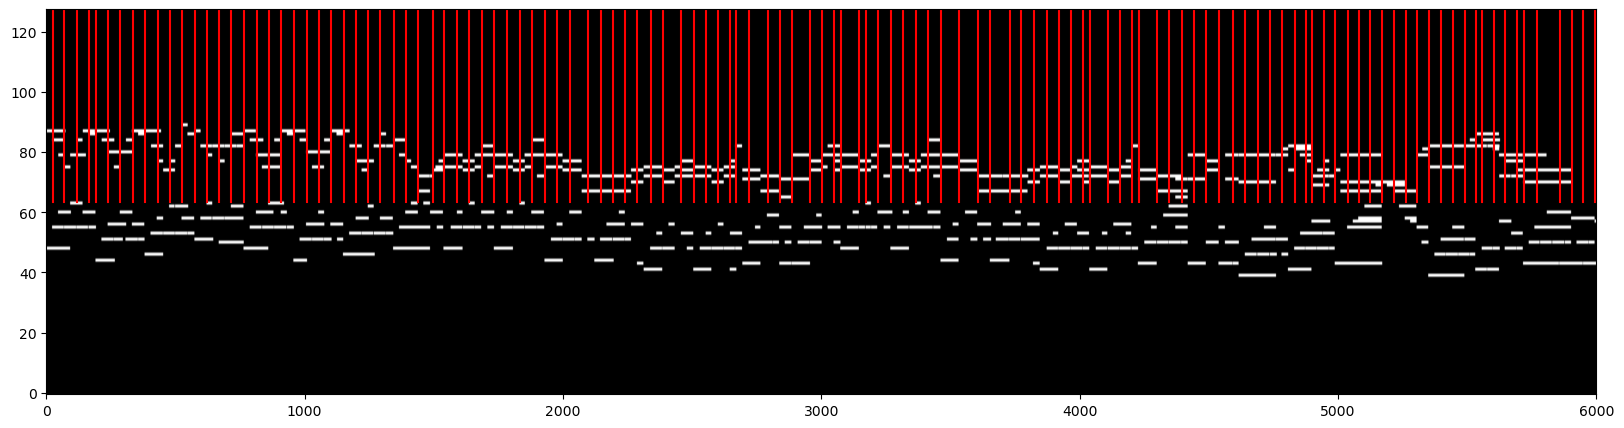

In [6]:
fig, ax = plt.subplots(figsize=(20, 5))
pr_seg, start_time, end_time = get_piano_roll(midi_recording)
ax.imshow(pr_seg, aspect="auto", origin="lower", cmap="gray")
# for b in beats1[np.logical_and(beats1 >= start_time, beats1 <= end_time)]:
#     ax.axvline(x=(b - start_time) * 100, ymin=0, ymax=0.5, color="g")
for b in beats2[np.logical_and(beats2 >= start_time, beats2 <= end_time)]:
    ax.axvline(x=(b - start_time) * 100, ymin=0.5, ymax=1, color="r")
ax.set_xbound(0, 6000)

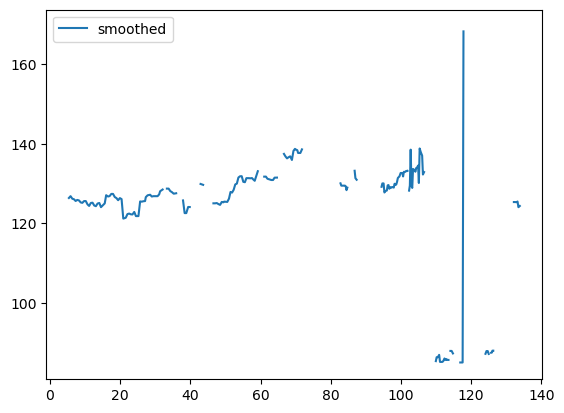

In [5]:
def move_by_pow_of_2(x, target):
    l2x, l2_target = np.log2(x), np.log2(target)
    offset = np.round(l2_target - l2x)
    return 2 ** (l2x + offset), offset


def bpm_over_time(
    beat_lens: np.ndarray,
    anchor_bpm: float,
    bin_precision: float = 0.05,
    wsize: int = 10,
    fill_nan: bool = True,
):
    def bpm_from_mode(n_samples, bins):
        mode_idx = n_samples.argmax()
        if n_samples[mode_idx] < sum(n_samples) / 2:
            return None
        mode_min, mode_max = bins[mode_idx], bins[mode_idx + 1]
        mode_samples = samples[np.logical_and(samples >= mode_min, samples <= mode_max)]
        return np.mean(mode_samples)

    ret = []
    for idx in range(wsize, len(beat_lens)):
        samples = 60 / beat_lens[idx - wsize : idx]
        bin_min, bin_max = np.log2(samples.min() - 0.01), np.log2(samples.max() + 0.01)
        bin_width = np.log2(1 + bin_precision)
        bins = 2 ** np.arange(bin_min, bin_max + bin_width, bin_width)
        n_samples, _ = np.histogram(samples, bins)
        window_bpm = bpm_from_mode(n_samples, bins)
        if window_bpm is None:
            # print(f"! BPM in window diverged: {samples}")
            ret.append(np.nan if fill_nan else ret[-1] if ret else anchor_bpm)
            continue
        ret.append(move_by_pow_of_2(window_bpm, anchor_bpm)[0])
    prefix = [np.nan if fill_nan else ret[0]] * wsize
    return np.array(prefix + ret)


xs = beats2
beat_lens = np.diff(xs, prepend=start_time)
bpms = bpm_over_time(beat_lens, 120, 0.1, wsize=10, fill_nan=True)
pow_offsets = [
    move_by_pow_of_2(60 / beat_len, bpm)[1] for beat_len, bpm in zip(beat_lens, bpms)
]
plt.plot(xs, bpms, label="smoothed")
# plt.plot(xs, pow_offsets, label='beat_pow_offset')
# plt.plot(xs, 60 / np.diff(xs, prepend=0), label='original')
plt.legend()
plt.show()

In [224]:
from fractions import Fraction

df_ = df.copy()


def remap_note_lens(onsets, note_lens, pow_offsets):
    def to_frac(xs):
        return xs.apply(lambda x: Fraction(x).limit_denominator(32))

    def modf(xs):
        decimal, integer = np.modf(xs)
        return to_frac(decimal), integer.astype(int)

    beat_lens = np.array([Fraction(2**offset) for offset in pow_offsets] + [0])
    beat_remap = np.cumsum(np.concatenate([[0], beat_lens]))
    onset_decimal, note_beat_idx = modf(onsets)
    onsets = beat_remap[note_beat_idx] + onset_decimal
    note_lens = to_frac(note_lens) * beat_lens[note_beat_idx]
    return onsets, note_lens


df_["onset_positions"], df_["note_values"] = remap_note_lens(
    df_["onset_positions"], df_["note_values"], pow_offsets
)
df_.sort_values("onset_positions").head(20)

,onset_positions,note_values,hand_parts
0,0,1,1.0
1,0,1,0.0
4,1/2,1,1.0
5,1/2,1/2,0.0
2,1,1,1.0
3,1,1,0.0
8,3/2,23/24,1.0
9,3/2,1,0.0
6,2,1/2,0.0
7,2,23/24,1.0
